In [42]:
import tensorflow as tf
import os
from matplotlib.image import imread #Open image as an array
import numpy as np
from skimage.transform import resize

In [43]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## Visualize Images

In [44]:
from PIL import Image

In [45]:
directory = 'Datasets/'
dirYES = os.listdir(directory + 'yes')
dirNO = os.listdir(directory + 'no')

#### Example image with tumor

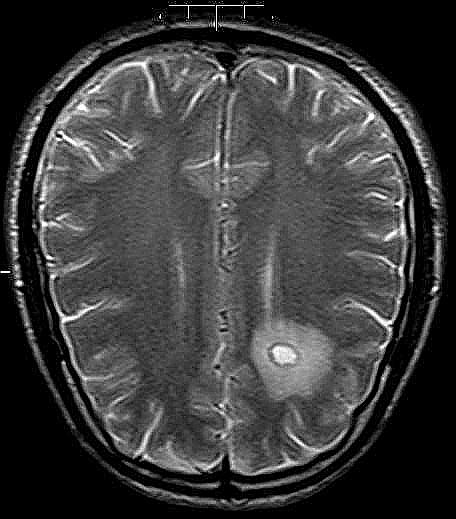

In [46]:
Image.open(directory + 'yes/' + dirYES[0])

#### Example image without tumor

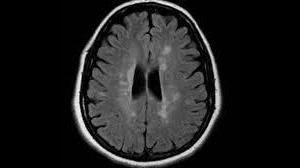

In [47]:
Image.open(directory + 'no/' + dirNO[6])

## Resize images

#### Resize images with tumors

In [48]:
resize = 224
Dataset = []
Label = []
for i in range(0,len(dirYES)):
    if dirYES[i].split('.')[1] == 'jpg':
        image = Image.open(directory + 'yes/' + dirYES[i])
        image = image.resize((resize,resize)) 
        image = np.array(image)
        Dataset.append(image)
        Label.append(1.0) # 1 For YES

#### Resize images without tumors

In [49]:
for i in range(0,len(dirNO)):
    if dirNO[i].split('.')[1] == 'jpg':
        image = Image.open(directory + 'no/' + dirNO[i])
        image = image.resize((resize,resize))
        image = np.array(image)
        Dataset.append(image)
        Label.append(0.0) # 0 for NO

### Reduce dimensionality and resize

In [50]:
for i in range(0,len(Dataset)):
    if len(Dataset[i].shape) > 2:
        Dataset[i] = Dataset[i][:,:,0]

In [51]:
Dataset = np.array(Dataset)
Label = np.array(Label)

In [52]:
Dataset = Dataset.reshape(Dataset.shape[0], Dataset.shape[1], Dataset.shape[2], 1)

In [53]:
Dataset.shape

(2826, 224, 224, 1)

### Display resized images

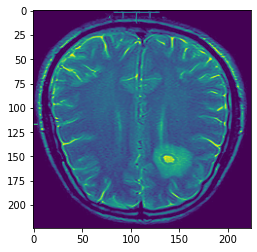

In [54]:
from matplotlib import pyplot as plt
plt.imshow(Dataset[0])
plt.show()

### Split Data

In [55]:
from sklearn.model_selection import train_test_split

In [56]:
X_train, X_test, y_train, y_test = train_test_split(Dataset, Label, test_size=0.2, random_state=42)

## Convolutional Neural Network

### Data Augmentation

In [57]:
from keras.preprocessing.image import ImageDataGenerator

In [58]:
train_generator = ImageDataGenerator(
    rescale=1./255
)

val_generator = ImageDataGenerator(rescale=1./255)

train_iterator = train_generator.flow(X_train, y_train, batch_size = 32, shuffle = True)

val_iterator = val_generator.flow(X_test, y_test, batch_size = 32, shuffle = False)

### Get pretrained model

In [59]:
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.python.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications.vgg16 import VGG16

In [60]:
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization,MaxPooling2D
from keras.optimizers import RMSprop

In [61]:
# Create model
model = Sequential()
# Add pretrained model
model.add(ResNet50(include_top = False, input_shape = (resize,resize,3), pooling = 'avg', weights = 'imagenet'))
# Add fully connected layer
model.add(Dense(64, activation = 'tanh'))
model.add(Dense(16, activation = 'tanh'))
model.add(Dense(1, activation = 'tanh'))

In [62]:
Model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 220, 220, 32)      832       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 110, 110, 32)     0         
 2D)                                                             
                                                                 
 dropout_5 (Dropout)         (None, 110, 110, 32)      0         
                                                                 
 conv2d_5 (Conv2D)           (None, 108, 108, 64)      18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 dropout_6 (Dropout)         (None, 54, 54, 64)       

In [63]:
Model.compile(optimizer=RMSprop(lr=0.001),loss="binary_crossentropy",metrics=["accuracy"])

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/rmsprop.py:143: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


### Train the model

In [64]:
Model.fit(train_iterator, epochs = 10, validation_data = val_iterator)

Epoch 1/10
71/71 [==============================] - 8s 95ms/step - loss: 0.0860 - accuracy: 0.9850 - val_loss: 0.1166 - val_accuracy: 0.9859
Epoch 2/10
71/71 [==============================] - 7s 94ms/step - loss: 0.0271 - accuracy: 0.9920 - val_loss: 0.0775 - val_accuracy: 0.9876
Epoch 3/10
71/71 [==============================] - 7s 93ms/step - loss: 0.0239 - accuracy: 0.9903 - val_loss: 0.1683 - val_accuracy: 0.9806
Epoch 4/10
71/71 [==============================] - 7s 94ms/step - loss: 0.0296 - accuracy: 0.9934 - val_loss: 0.1749 - val_accuracy: 0.9859
Epoch 5/10
71/71 [==============================] - 7s 93ms/step - loss: 0.0373 - accuracy: 0.9898 - val_loss: 0.1386 - val_accuracy: 0.9876
Epoch 6/10
71/71 [==============================] - 7s 93ms/step - loss: 0.0324 - accuracy: 0.9912 - val_loss: 0.1561 - val_accuracy: 0.9859
Epoch 7/10
71/71 [==============================] - 7s 93ms/step - loss: 0.0255 - accuracy: 0.9916 - val_loss: 0.1207 - val_accuracy: 0.9912
Epoch 8/10
71

## Results

### Confusion Matrix

In [91]:
ypred = Model.predict(X_test)

18/18 [==============================] - 0s 16ms/step


In [88]:
from sklearn.metrics import confusion_matrix

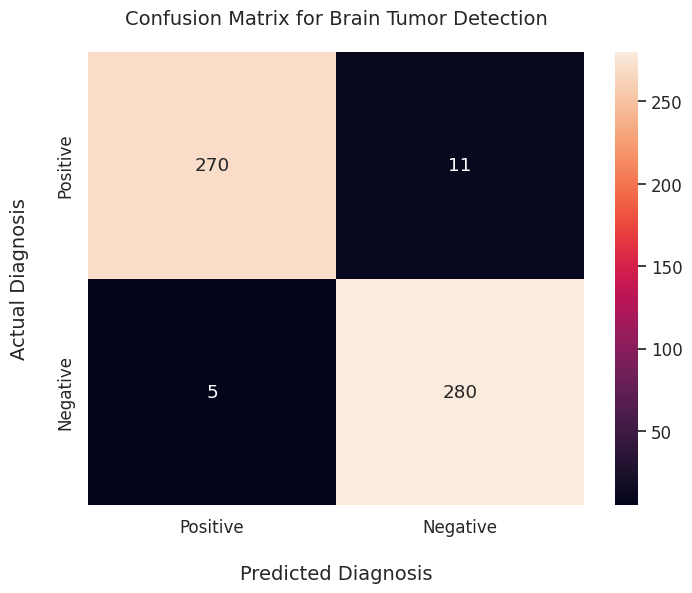

In [72]:
import seaborn as sns

plt.figure(figsize=(8,6), dpi=100)

sns.set(font_scale = 1.1)

ax = sns.heatmap(confusion_matrix(y_test, ypred), annot=True, fmt='d', )

ax.set_xlabel("Predicted Diagnosis", fontsize=14, labelpad=20)
ax.xaxis.set_ticklabels(['Positive','Negative'])


ax.set_ylabel("Actual Diagnosis", fontsize=14, labelpad=20)
ax.yaxis.set_ticklabels(['Positive', 'Negative'])

ax.set_title("Confusion Matrix for Brain Tumor Detection", fontsize=14, pad=20)

plt.show()

In [73]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report

In [79]:
print("F1 Score: ", f1_score(y_test, ypred))
print("Precision: ", precision_score(y_test, ypred))
print("Recall: ",recall_score(y_test, ypred))
print("Accuracy: ",accuracy_score(y_test, ypred))

F1 Score:  0.9722222222222222
Precision:  0.9621993127147767
Recall:  0.9824561403508771
Accuracy:  0.9717314487632509


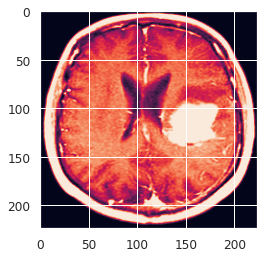

In [105]:
plt.imshow(X_test[50])
plt.show()

In [106]:
Model.predict(X_test)[50],y_test[50]

18/18 [==============================] - 0s 14ms/step


(array([1.], dtype=float32), 1.0)

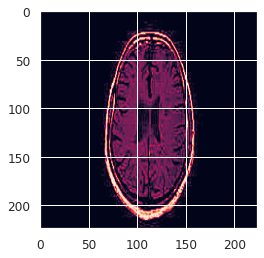

In [107]:
plt.imshow(X_test[70])
plt.show()

In [108]:
Model.predict(X_test)[70],y_test[70]

18/18 [==============================] - 0s 15ms/step


(array([0.], dtype=float32), 0.0)